In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import time
from IPython.display import clear_output

import torch
import torch.optim as optim
import torch.nn as nn
import torch.utils.data as Tdata
import torch.nn.functional as F
import torch.distributions as TD
from torch.utils.data import DataLoader

import os
import sys
sys.path.append('../../homeworks') # to grab dgm_utils from ../../homeworks directory

if torch.cuda.is_available():
    DEVICE = 'cuda'
    GPU_DEVICE = 2
    torch.cuda.set_device(GPU_DEVICE)
else:
    DEVICE='cpu'
# DEVICE='cpu'

import warnings
warnings.filterwarnings('ignore')

# dgm_utils
from dgm_utils import plot_training_curves, show_samples
from dgm_utils import visualize_2d_samples, visualize_2d_densities, visualize_2d_data
from dgm_utils import train_model

# <center>Deep Generative Models</center>
## <center>Seminar 14</center>

<center><img src="pics/AIMastersLogo.png" width=600 /></center>
<center>12.12.2022</center>


## Plan

1. Noise Conditional Score Network (NCSN)

2. Denoising Diffusion Probabilistic Model (DDPM)

### Problem setup. Target distribution.

The code and visualizations are based on the following [github](https://github.com/acids-ircam/diffusion_models): [notebook_1](https://github.com/acids-ircam/diffusion_models/blob/main/diffusion_01_score.ipynb), [notebook_2](https://github.com/acids-ircam/diffusion_models/blob/main/diffusion_02_model.ipynb)

In [3]:
from sklearn.datasets import make_swiss_roll

def sample_swiss_roll(size, noise=0.5):
    x, _= make_swiss_roll(size, noise=noise)
    return x[:, [0, 2]] / 10.0

def train_test_split(data):
    count = data.shape[0]
    split = int(0.8 * count)
    train_data, test_data = data[:split], data[split:]
    return train_data, test_data

Samples from target distribution

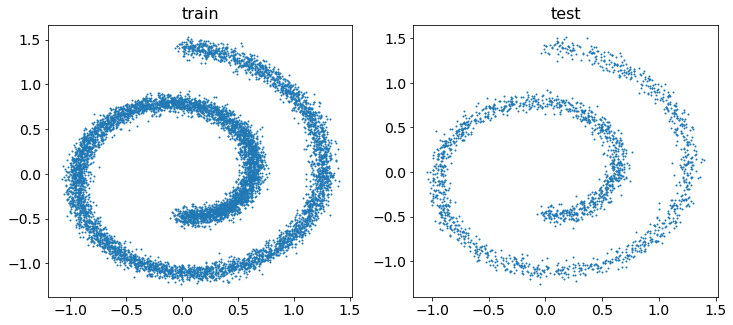

In [4]:
COUNT = 10000

train_data, test_data= train_test_split(sample_swiss_roll(COUNT))
visualize_2d_data(train_data, test_data)

## Denoising score matrching

We have samples $Z$ from the unknown distribution of interest $p^*$

**Problem**: Model distribution $p^*$ (e.g. obtain new samples)

Consider **noising kernel**:

$$ q_{\sigma}(\mathbf{z} | \mathbf{z}') = \mathcal{N}(\mathbf{z} | \mathbf{z}', \sigma^2 I)$$

Noised distribution of interest:

$$ p^*_{\sigma}(\mathbf{z}) = \int\limits_{\mathbf{Z}} q_{\sigma}(\mathbf{z} | \mathbf{z}') p^*(\mathbf{z}') d \mathbf{z}' $$

Recall the **denoising score matching** optimization problem: 

$$
L_{\text{MSE noised}}(\theta) = \frac{1}{2}E_{\mathbf{\mathbf{z}} \sim p^*_{\sigma}(\mathbf{z})} \left[ \left\lVert s(\mathbf{z}|\theta, \sigma) - \nabla_{\mathbf{z}} \log p^*_{\sigma}(\mathbf{z}) \right\lVert_2^2 \right] \rightarrow \min\limits_{\theta}
$$

Alternative formulation **(Denoising score matching)** ([Vincent et. al., 2010](http://www-labs.iro.umontreal.ca/~vincentp/Publications/smdae_techreport_1358.pdf), [Song & Ermon, 2020](https://arxiv.org/pdf/1907.05600.pdf)):

$$
L_{\text{denoising matching}}(\theta) = \frac{1}{2}E_{\mathbf{z}' \sim p^*(\cdot)} E_{\mathbf{z} \sim q_{\sigma}(\mathbf{z} | \mathbf{z}')}  \left[ \left\Vert s(\mathbf{z}|\theta, \sigma) - \nabla_{\mathbf{z}} \log q_{\sigma}(\mathbf{z}\mid\mathbf{z}') \right\lVert_2^2 \right] = \\
= \frac{1}{2}E_{\mathbf{z}' \sim p^*(\cdot)} E_{\mathbf{z} \sim q_{\sigma}(\mathbf{z} | \mathbf{z}')}  \left[ \left\Vert s(\mathbf{z}|\theta, \sigma) + \frac{\mathbf{z} - \mathbf{z}'}{\sigma^{2}} \right\lVert_2^2 \right] \rightarrow \min\limits_{\theta}
$$



#### **Sampling** from $p^*_{\sigma}$:

Discretization of **Langevin** process (**Euler-Maruyama** simiulation): 

1. Sample $\mathbf{z}_{0} \sim p_{z_0}$

2. Fix $\tau > 0$ and for $k \in {0, 1, \dots K}$ do: 

$$\mathbf{z}_{(k + 1) \tau} = \mathbf{z}_{k \tau} + \tau \frac{1}{2} s(\mathbf{z}_{k \tau}| \theta, \sigma) + \Delta \mathbf{W}_k\, ,\\
\text{where } \Delta \mathbf{W}_k \sim \mathcal{N}(0, \tau I)$$

<center><img src="pics/em_demo2.png" width=800 /></center>

#### Denoising score matching properties:

<span style="color:green">**Pros**</span>

* $s(\mathbf{z}|\theta, \sigma)$ **accurately estimates** true $\nabla_{\mathbf{z}} \log p^*_{\sigma}(\mathbf{z})$ as $\sigma$ increases.

* Improves the convergence of **Langevin dynamics** as $\sigma$ increases.

* Leverages the **manifold hypothesis** (in case $p^*$ is images distribution)

<span style="color:red">**Cons**</span>

* $p^*_{\sigma}(\mathbf{z})$ **diverges** from $p^*(\mathbf{z})$ as $\sigma$ increases.

**Question** How to solve the aforementioned problem?

## Noise Conditional Score Network (NCSN)

Proposed in [Song & Ermon, 2020](https://arxiv.org/pdf/1907.05600.pdf)

<center><img src="pics/ncsn_2.png" width=1000 /></center>

Consider sequence $\sigma_1 > \sigma_2 > \dots > \sigma_{L}$

* $\sigma_L$ is small enough to approximate the data distribution: $p^*_{\sigma_L} \approx p^*$

* $\sigma_1$ is large enough to satisfy the good convergence properties

**Objective** for $\sigma_l$ , $l \in \{1, 2, \dots , L\}$:

$$
L_{\text{denoising matching}, \sigma_l}(\theta) 
= \frac{1}{2}E_{\mathbf{z}' \sim p^*(\cdot)} E_{\epsilon \sim \mathcal{N}(0, \sigma_l^2 I)}  \left[ \left\Vert s(\mathbf{z}' + \epsilon |\theta, \sigma_l) - \frac{(-\epsilon)}{\sigma_l^{2}} \right\lVert_2^2 \right] \rightarrow \min\limits_{\theta}
$$

* $-\epsilon$ is the noise which sould be added to the **noised** datum $\mathbf{z}' + \epsilon$ to obtain the **denoised** datum $\mathbf{z}'$

**Ultimate objective**: 

$$L_{NCSN}(\theta) = \frac{1}{2}\sum\limits_{l = 1}^{L} \lambda(\sigma_l) \left\{E_{\mathbf{z}' \sim p^*(\cdot)} E_{\epsilon \sim \mathcal{N}(0, \sigma_l^2 I)}  \left[ \left\Vert s(\mathbf{z}' + \epsilon |\theta, \sigma_l) - \frac{(-\epsilon)}{\sigma_l^{2}} \right\lVert_2^2 \right]\right\} \rightarrow \min\limits_{\theta}$$

* $\lambda(\sigma_l) = \sigma_l^2$ 

**Question** Why is $\lambda(\sigma_l) = \sigma_l^2$ a good choice for $\lambda(\sigma_l)$?

$\sigma_l^2$ is the magnitude of $\left\Vert s(\mathbf{z}' + \epsilon |\theta, \sigma_l) - \frac{(-\epsilon)}{\sigma_l^{2}} \right\lVert_2^2$

**Question** How to model score function $s(\cdot | \theta, \sigma)$ given different noise magnitude $\sigma$?

* $2D$ case:

```python
noise2emb1 = torch.nn.Embedding(L, emb_dim1) # (c , w, h)
noise2emb2 = torch.nn.Embedding(L, emb_dim2)
...
# `sigma` is a given noise level (bs, 1)
# `x` is a noised datum (bs, 2)
sigma_emb1 = noise2emb1(sigma_index[sigma]) # (bs, emb_dim1)
sigma_emb2 = noise2emb2(sigma_index[sigma]) # (bs, emb_dim2)
...
score = NN(x, sigma_emb1, sigma_emb2, ...)
```

* image data case:

    We also learn embeddings. See the [paper](https://arxiv.org/pdf/1907.05600.pdf) for the details. The sigma embeddings are used similar to `Adaptive Normalization` we use when implementing *StyleGAN*

#### Sampling from `NCSN`

**"Annealed" Langevin Dynamics**:

<center><img src="pics/annealed_langevin.png" width=600 /></center>

**Question** Why does we set discretization step $\alpha_i = \epsilon \frac{\sigma_i^2}{\sigma_L^2}$?

### Implementation

**Euler-Maruyama** simulation:

In [5]:
def sample_langevin(score_function, x, n_steps=100, eps=1e-2, decay=1.0, store_history=False):
    if store_history:
        x_sequence = [x.detach().cpu()]

    for s in range(n_steps):

        ## Langevin dynamics
        z_t = torch.randn(x.size()).to(x)
        x = x + (eps / 2) * score_function(x) + (np.sqrt(eps) * z_t)
        eps *= decay

        if store_history:
            x_sequence.append(x.detach().cpu())
    if store_history:
        return x, torch.cat(x_sequence)
    return x

Conditional score function

In [6]:
class ConditionalLinear(nn.Module):

    def __init__(self, num_in, num_out, num_classes, use_batch_norm=True):
        super().__init__()
        self.num_in = num_in
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)
        if use_batch_norm:
            self.batch_norm = nn.BatchNorm1d(num_out)
        self.scale_embed = nn.Embedding(num_classes, num_out)
        self.shift_embed = nn.Embedding(num_classes, num_out)
        self.scale_embed.weight.data.uniform_()

    def forward(self, x, sigma_indices):
        '''
        x      : (bs, num_in)
        sigmas : (bs, 1)
        '''
        out = self.lin(x) # (bs, num_out)
        if hasattr(self, 'batch_norm'):
            out = self.batch_norm(out)
        scale = self.scale_embed(sigma_indices).view(-1, self.num_out) # (bs, num_out)
        shift = self.shift_embed(sigma_indices).view(-1, self.num_out) # (bs, num_out)
        assert scale.shape == out.shape
        out = scale * out + shift # (bs, num_out)
        return out

class ConditionalSequential(nn.Sequential):

    def forward(self, x, sigma_indices):
        for module in self._modules.values():
            if isinstance(module, ConditionalLinear):
                x = module(x, sigma_indices)
            else:
                x = module(x)
        return x

class ConditionalFullyConnectedMLP(nn.Module):

    def __init__(
        self, 
        input_dim, 
        hiddens, 
        output_dim,
        num_classes,
        use_batch_norm=True,
        activation_gen = lambda : nn.ReLU()
    ):

        assert isinstance(hiddens, list)
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hiddens = hiddens

        model = []
        prev_h = input_dim
        for h in hiddens:
            model.append(ConditionalLinear(
                prev_h, h, num_classes, use_batch_norm=use_batch_norm))
            model.append(activation_gen())
            prev_h = h
        model.append(ConditionalLinear(
            hiddens[-1], output_dim, num_classes, use_batch_norm=use_batch_norm))
        self.net = ConditionalSequential(*model)

    def forward(self, x, sigma_indices):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        return self.net(x, sigma_indices).view(batch_size, self.output_dim)

class ConditionalScoreFunction2D(ConditionalFullyConnectedMLP):

    def __init__(self, num_classes, dim=2, hiddens=[128, 128]):
        super().__init__(
            dim, hiddens, dim, num_classes, activation_gen = lambda : nn.ReLU())

**NCSN** objective:

$$L_{NCSN} = \frac{1}{2}\sum\limits_{l = 1}^{L} \sigma_l^2 \left\{E_{\mathbf{z}' \sim p^*(\cdot)} E_{\epsilon \sim \mathcal{N}(0, \sigma_l^2 I)}  \left[ \left\Vert s(\mathbf{z}' + \epsilon |\theta, \sigma_l) - \frac{(-\epsilon)}{\sigma_l^{2}} \right\lVert_2^2 \right]\right\} \rightarrow \min\limits_{\theta}$$

In [7]:
class NCSN(ConditionalScoreFunction2D):

    def __init__(self, sigmas, dim=2, hiddens=[128, 128]):
        '''
        sigmas : tensor (L,) - used noisy levels
        '''
        L = len(sigmas)
        super().__init__(L, dim, hiddens)
        self.register_buffer('sigmas', torch.tensor(sigmas).float())
        self.L = L

    def loss(self, samples):
        '''
        samples : tensor (bs, 2)
        '''
        bs = samples.size(0)
        # indices of noise levels for each datum in the batch
        labels = torch.randint(0, self.L, (bs,)).to(samples.device) # (bs,)
        # noise levels for each datum in the batch
        used_sigmas = torch.gather(self.sigmas, 0, labels).to(samples).view(-1, 1) # (bs, 1)
        # standard normal perturbation
        std_eps = torch.randn_like(samples) # (bs, 2)

        scores = self.forward(samples + std_eps * used_sigmas, labels) # (bs, 2)
        targets = - std_eps / used_sigmas # (bs, 2)
        loss = 0.5 * ((scores - targets) ** 2).sum(dim=-1) * used_sigmas.squeeze().pow(2) # (bs,)
        return {'ncsn_loss': loss.mean()}

    def score(self, x, label, return_sigma=False):
        '''
        label \in {0, 1, .. , L-1}
        '''
        assert label >= 0
        assert label < self.L
        labels = torch.zeros(x.size(0), dtype=torch.int64, device=x.device) + label
        scores = self.forward(x, labels)
        if not return_sigma:
            return scores
        return scores, self.sigmas[label].item()

    def sample(self, n, T, tau, save_history=False):
        '''
        Samples using Annealed Langevin Dynamics
        n : int :  number of samples to draw
        T : int : number of Euler-Maruyama steps per each noise level
        tau : basic discretization step (a.k.a. \epsilon in the listing of algorithm)
        '''
        history = []
        with torch.no_grad():
            # sample from initial distribution
            z = torch.randn((n, self.input_dim)).to(self.sigmas)
            if save_history:
                history.append(z.cpu())

            for l in range(self.L):
                alpha = tau * self.sigmas[l].pow(2).item()/self.sigmas[-1].pow(2).item()
                z = sample_langevin(lambda x: self.score(x, l), z, n_steps=T, eps=alpha)

                if save_history:
                    history.append(z.cpu())

            if save_history:
                return z, history
            return z

Training

In [10]:
EPOCHS = 2000
BATCH_SIZE = 1024
LR = 1e-3
USE_CUDA=True
SIGMAS = np.geomspace(1., 0.05, 8)
print('SIGMAS: ', SIGMAS)

score_model = NCSN(SIGMAS).cuda()
train_loader = DataLoader(torch.tensor(train_data).float(), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(torch.tensor(test_data).float(), batch_size=BATCH_SIZE)

train_losses, test_losses = train_model(
    score_model, 
    train_loader, 
    test_loader, 
    epochs=EPOCHS, 
    lr=LR, 
    use_tqdm=True, 
    use_cuda=USE_CUDA,
    loss_key='ncsn_loss'
)

SIGMAS:  [1.         0.65183634 0.42489062 0.27695915 0.18053204 0.11767734
 0.07670637 0.05      ]


  0%|          | 0/2000 [00:00<?, ?it/s]

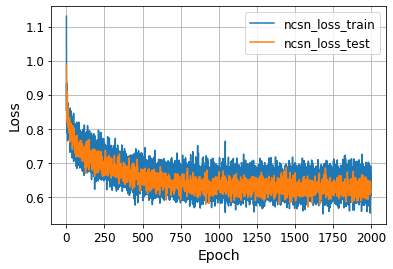

In [11]:
plot_training_curves(train_losses, test_losses)

Let's see the learned score functions

In [12]:
from seminar14_utils import plot_score_function

In [13]:
def noise_data(data, sigma=1.0):
    return data + np.random.randn(*data.shape) * sigma

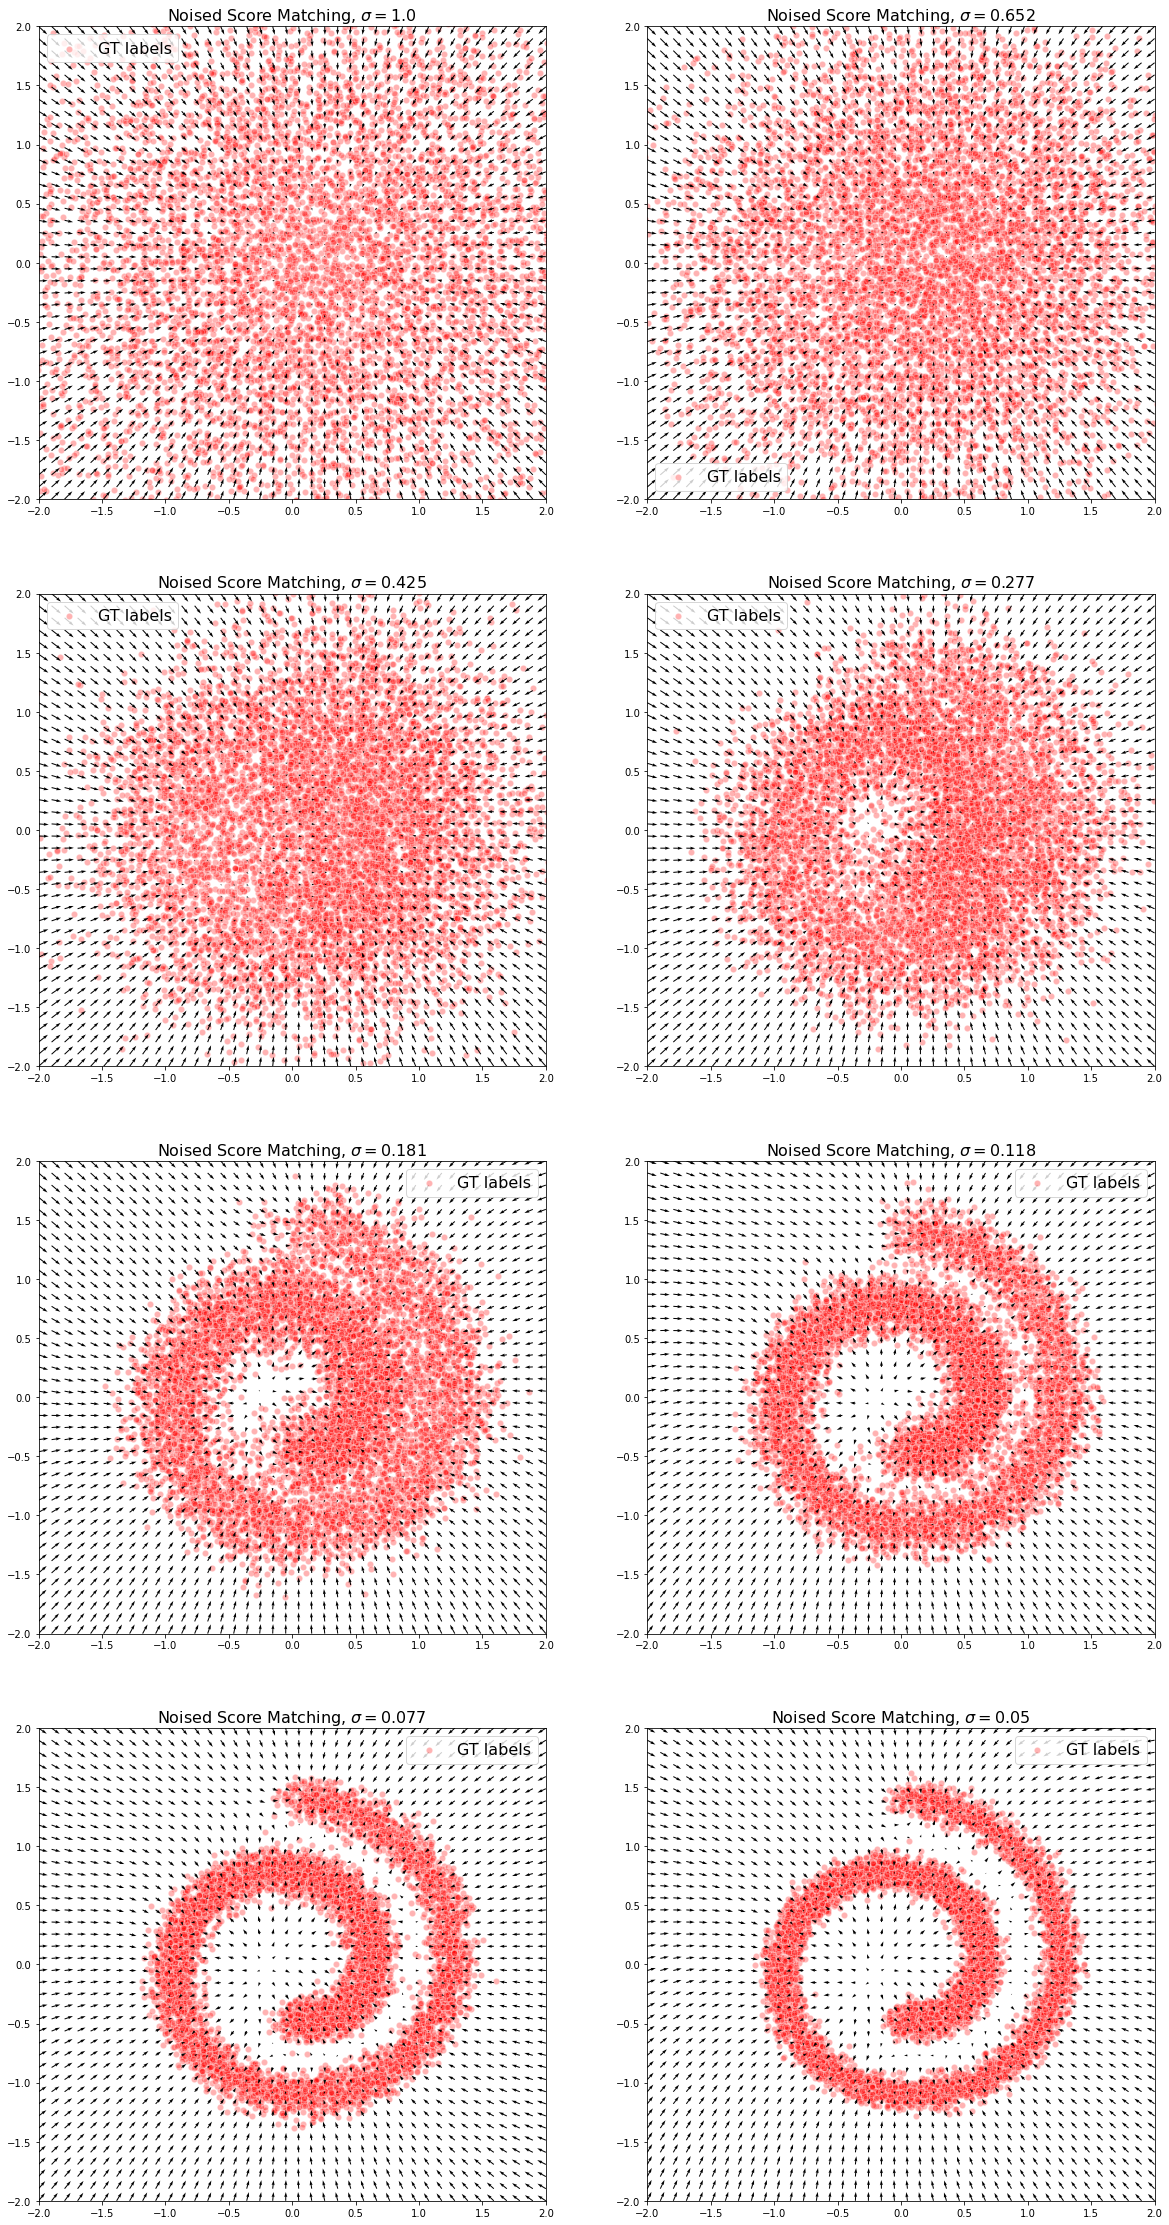

In [14]:
score_model.eval()
fig, axs = plt.subplots(4, 2, figsize=(20, 40))
for l, ax in enumerate(axs.flatten()):
    sigma = score_model.sigmas[l].item()
    noised_data = noise_data(train_data, sigma)
    plot_score_function(
        lambda x: score_model.score(x, l), noised_data, r'Noised Score Matching, $\sigma = {}$'.format(round(sigma, 3)), ax=ax)
    ax.legend(fontsize=16)
plt.show()

Samples from the model

In [66]:
score_model.eval()
z, z_history = score_model.sample(5000, 100, 1e-3, save_history=True)

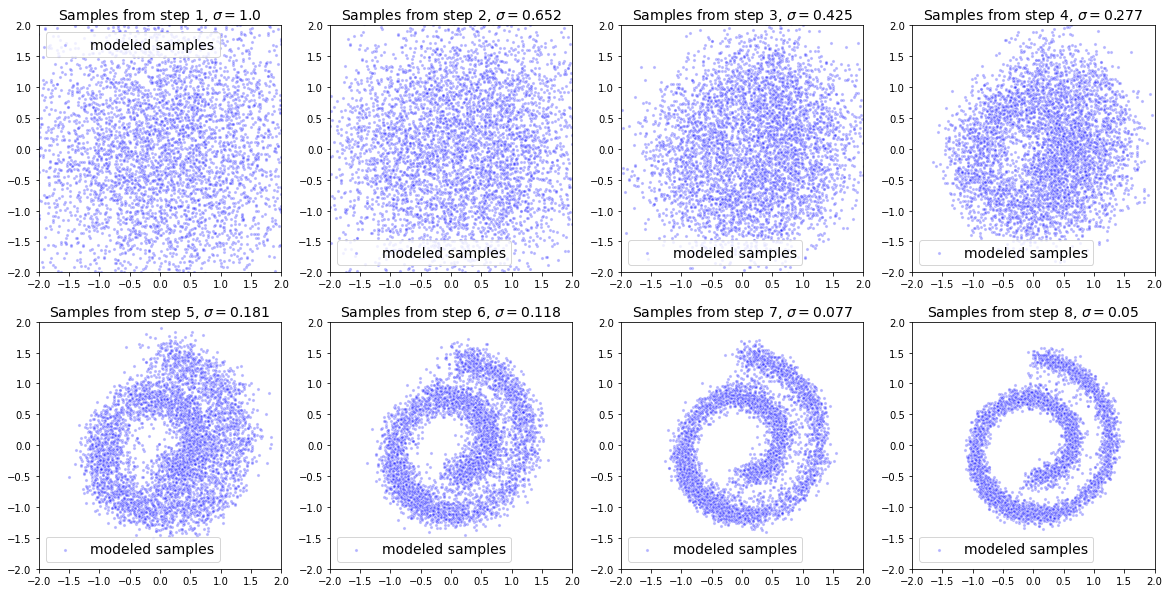

In [70]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
for l, ax in enumerate(axs.flatten()):
    z_curr = z_history[l + 1].cpu().numpy()
    ax.scatter(z_curr[:, 0], z_curr[:, 1], alpha=0.3, color='blue', edgecolor='white', s=10, label='modeled samples')
    sigma = score_model.sigmas[l].item()
    ax.set_xlim(*(-2, 2))
    ax.set_ylim(*(-2, 2))
    ax.set_title('Samples from step {}, $\sigma ={}$'.format(l + 1, round(sigma, 3)), fontsize=14)
    ax.legend(fontsize=14)
plt.show()

## Denoising Diffusion Probabilistic Model (DDPM)

Proposed in [Ho et. al., 2020](https://arxiv.org/pdf/2006.11239.pdf), utilizes ideas from [Sohl-Dickstein et. al., 2015](https://arxiv.org/pdf/1503.03585.pdf)

<center><img src="pics/ddpm.png" width=800 /></center>

### Forward **noising** process $q(\mathbf{x}_t | \mathbf{x}_{t - 1})$

We have data samples $X_0$ from the unknown distribution of interest $q_0^*$.

Consider the **Markov Chain** which progressively **noises** data:

$$\mathbf{x}_t = \sqrt{1 - \beta_t} \mathbf{x}_{t - 1} + \sqrt{\beta_t} \cdot \epsilon , \quad \epsilon \sim \mathcal{N}(0, I)$$

* Initial distribution $q_0 = q_0^*$.

* $\beta_t \in (0, 1) \,, \, t \in \{0, 1, \dots T\}$. Theoretically, $T \rightarrow \infty$. 

* $\beta_t$ are **fixed number** (usually, we **don't learn them**). Practically, $T$ is a large number, $0 < \beta_t \ll 1$

#### Properties

1. Stationary distribution $q_{\infty} \sim \mathcal{N}(0, I)$ 

2. Define $\alpha_t = 1 - \beta_t$ , $\bar{\alpha}_t = \prod\limits_{s = 1}^{t} \alpha_t$. Then:

$$q(\mathbf{x}_t | \mathbf{x}_0) = \mathcal{N}\left(\mathbf{x}_t \middle| \sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1 - \bar{\alpha}_t)I\right)$$

3. Define: 

$$\tilde{\mu}(\mathbf{x}_t, \mathbf{x}_0) = \frac{\sqrt{\bar{\alpha}_{t - 1}} \beta_t}{1 - \bar{\alpha}_t} \mathbf{x}_0 + \frac{\sqrt{\alpha_t}(1 - \bar{\alpha}_{t - 1})}{1 - \bar{\alpha}_t}\mathbf{x}_t\\\tilde{\beta}_t = \frac{1 - \bar{\alpha}_{t - 1}}{1 - \bar{\alpha}_t}$$

    Then:
    
$$q(\mathbf{x}_{t - 1} | \mathbf{x}_t, \mathbf{x}_0) = \mathcal{N}\left(\mathbf{x}_{t - 1} \middle| \tilde{\mu}(\mathbf{x}_t, \mathbf{x}_0), \tilde{\beta}_t I\right)$$

In [119]:
class ConstantsSheduler:
    
    def __init__(self, betas):
        self.betas = betas
        self.T = len(betas)
    
    def beta(self, t):
        assert t <= self.T
        return self.betas[t - 1]
    
    def alpha(self, t):
        assert t <= self.T
        return 1. - self.beta(t)
    
    def alpha_bar(self, t):
        assert t <= self.T
        prod = 1.
        for s in range(1, t + 1):
            prod *= self.alpha(s)
        return prod
    
    def beta_tilda(self, t):
        assert t <= self.T
        if t == 1:
            return self.betas[0]
        return ((1. - self.alpha_bar(t - 1))/(1. - self.alpha_bar(t)))*self.beta(t)

#### Forward (**noising**) process demonstration:

In [72]:
def noise_data_kernel(data, alpha):
    return np.sqrt(alpha) * data + np.random.randn(*data.shape) * np.sqrt(1. - alpha)

In [115]:
# similar to the shedule proposed by Ho et. al., 2020
beta = np.linspace(1e-4, 0.004, 80)
CS = ConstantsSheduler(beta)

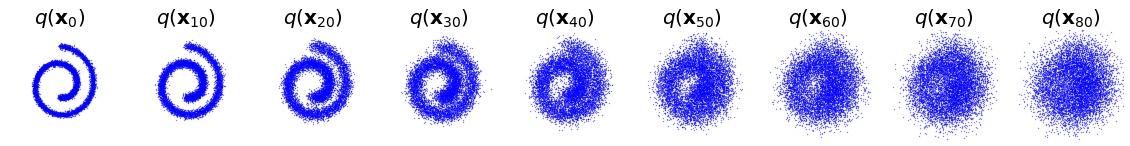

In [117]:
fig, axs = plt.subplots(1, 9, figsize=(20, 2.0))
for l, ax in enumerate(axs.flatten()):
    t = l * 10
    data = noise_data_kernel(train_data, CS.alpha_bar(t))
    ax.scatter(data[:, 0], data[:, 1], alpha=0.7, color='blue', s=0.1)
    ax.set_xlim(*(-2, 2))
    ax.set_ylim(*(-2, 2))
    ax.set_title(r'$q(\mathbf{x}_{' + str(t) + '})$', fontsize=20)
    ax.axis('off')
plt.show()

### Backward **denoising** process $p_{\theta}(\mathbf{x}_{t - 1} | \mathbf{x}_{t})$

See the [post](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/) form more details

We want to **maximize the likelihood**:

$$E_{\mathbf{x}_0 \sim q(\mathbf{x}_0)} \log p_{\theta}(\mathbf{x}_0) \rightarrow \max\limits_{\theta}$$

Instead we maximize the **lower bound**:

$$E_{x_0 \sim q_{\mathbf{x}_0}} \log p_{\theta}(\mathbf{x}_0) \geq E_{\mathbf{x}_{0:T} \sim q(\mathbf{x}_{0:T})} \log \frac{p_{\theta}(\mathbf{x}_{0:T})}{q(\mathbf{x}_{1:T}|\mathbf{x}_0)} \rightarrow \max\limits_{\theta}$$

By utilizing the structure of the "decoder" $q$ the objective can be rewritten as `DDPM` **objective**:


\begin{align}
L_{\text{DDPM}}(\theta) &= E_{\mathbf{x}_{0:T} \sim q(\mathbf{x}_{0:T})}\left[-l_{T}(\mathbf{x}_T, \mathbf{x}_0) - \sum\limits_{t=2}^{T} l_{t-1}(\mathbf{x}_t, \mathbf{x}_0) - l_{0}(\mathbf{x}_1, \mathbf{x}_0) \right] \rightarrow \max\limits_{\theta}\\
l_{T}(\mathbf{x}_T, \mathbf{x}_0) &= D_{KL}(q(\mathbf{x}_{T}\mid\mathbf{x}_{0}) \Vert p_{\theta}(\mathbf{x}_{T})) \\
l_{t-1}(\mathbf{x}_t, \mathbf{x}_0) &= D_{KL}(q(\mathbf{x}_{t-1}\mid\mathbf{x}_{t},\mathbf{x}_{0}) \Vert p_{\theta}(\mathbf{x}_{t-1}\mid\mathbf{x}_{t})) \\
l_{0}(\mathbf{x}_1, \mathbf{x}_0) &= - \log p_{\theta}(\mathbf{x}_{0}\mid\mathbf{x}_{1}) 
\end{align}

#### Treating $L_{\text{DDPM}}$ objective terms:

* $l_{T}(\mathbf{x}_T, \mathbf{x}_0)$

$l_{T}(\mathbf{x}_T, \mathbf{x}_0)$ <span style="color:green">is fixed</span>. **Question**: Why?

We set $p_{\theta}(\mathbf{x}_T)$ to be standard Gaussian

* $l_{t-1}(\mathbf{x}_t, \mathbf{x}_0) = D_{KL}(q(\mathbf{x}_{t-1}\mid\mathbf{x}_{t},\mathbf{x}_{0}) \Vert p_{\theta}(\mathbf{x}_{t-1}\mid\mathbf{x}_{t}))$

**Question**: How to model $p_{\theta}(\mathbf{x}_{t-1}\mid\mathbf{x}_{t})$ and estimate $l_{t-1}(\mathbf{x}_t, \mathbf{x}_0)$?

$$p_{\theta}(\mathbf{x}_{t-1}\mid\mathbf{x}_{t}) \sim \mathcal{N}\left(\mu(\mathbf{x}_t, \theta, t), \tilde{\beta}_t I\right)$$

Then the $KL$ divergence has the **closed form expression**:

$$l_{t-1}(\mathbf{x}_t, \mathbf{x}_0) = D_{KL}\left(\mathcal{N}\left(\tilde{\mu}(\mathbf{x}_t, \mathbf{x}_0), \tilde{\beta}_t I\right) \middle\Vert \mathcal{N}\left(\mu(\mathbf{x}_t, \theta, t), \tilde{\beta}_t I\right)\right) = \\ = \frac{1}{2 \tilde{\beta}_t}\left\Vert\tilde{\mu}(\mathbf{x}_t, \mathbf{x}_0) -  \mu(\mathbf{x}_t, \theta, t)\right\Vert_2^2 + C_{t - 1}$$


#### Alternative parametrization: 

Recall: 

$$\mathbf{x}_t = \sqrt{\bar{\alpha}_t} \mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon_{\mathbf{x}_t} \, , \quad \epsilon_{\mathbf{x}_t} \sim \mathcal{N}(0, I)$$

Given $\mathbf{x}_t$ let's define a `Neural Network` $\epsilon_{\theta}(\mathbf{x}_t, t)$ such that:

$$\epsilon_{\theta}(\mathbf{x}_t, t) \approx \epsilon_{\mathbf{x}_t}$$

Using this parametrization, one can define:

$$\mu(\mathbf{x}_t, \theta, t) := \tilde{\mu}\big{(}\mathbf{x}_t, \mathbf{x}_0(\mathbf{x}_t, \epsilon_{\theta}(\mathbf{x}_t, t))\big{)} = \frac{\sqrt{\bar{\alpha}_{t - 1}} \beta_t}{1 - \bar{\alpha}_t} \hat{\mathbf{x}}_0(\mathbf{x}_t, \epsilon_{\theta}(\mathbf{x}_t, t)) + \frac{\sqrt{\alpha_t}(1 - \bar{\alpha}_{t - 1})}{1 - \bar{\alpha}_t}\mathbf{x}_t$$

**Question**: What is $\mathbf{x}_0(\mathbf{x}_t, \epsilon_{\theta}(\mathbf{x}_t, t))$?

In the equation above:

$$\hat{\mathbf{x}}_0(\mathbf{x}_t, \epsilon_{\theta}(\mathbf{x}_t, t)) = \frac{1}{\sqrt{\bar{\alpha}_t}}(\mathbf{x}_t - \sqrt{1 - \bar{\alpha}_t} \epsilon_{\theta}(\mathbf{x}_t, t))$$

The **ground truth** mean vector $\tilde{\mu}(\mathbf{x}_t, \mathbf{x}_0)$ permits the same parametrization:

$$\tilde{\mu}(\mathbf{x}_t, \mathbf{x}_0) := \tilde{\mu}\big{(}\mathbf{x}_t, \mathbf{x}_0(\mathbf{x}_t, \epsilon_{\mathbf{x}_t})\big{)} = \frac{\sqrt{\bar{\alpha}_{t - 1}} \beta_t}{1 - \bar{\alpha}_t} \mathbf{x}_0(\mathbf{x}_t, \epsilon_{\mathbf{x}_t}) + \frac{\sqrt{\alpha_t}(1 - \bar{\alpha}_{t - 1})}{1 - \bar{\alpha}_t}\mathbf{x}_t$$

**Finally**:

$$L_{t - 1}(\theta) - C_{t - 1} = E_{\mathbf{x}_{0:T} \sim q(\mathbf{x}_{0:T})} l_{t-1}(\mathbf{x}_t, \mathbf{x}_0) - C_{t - 1} = E_{\mathbf{x}_{0} \sim q(\mathbf{x}_{0})} E_{\epsilon_{\mathbf{x}_t} \sim \mathcal{N}(0, I)} \frac{1}{2 \tilde{\beta}_t}\left\Vert\tilde{\mu}\big{(}\mathbf{x}_t , \mathbf{x}_0\big{)} -  \tilde{\mu}\big{(}\mathbf{x}_t , \hat{\mathbf{x}}_0(\mathbf{x}_t, \epsilon_{\theta}(\mathbf{x}_t, t))\big{)}\right\Vert_2^2 = \\ = \left[ \frac{\beta_t^2}{2 \tilde{\beta}_t \alpha_t (1 - \bar{\alpha}_t)}\right]E_{\mathbf{x}_{0} \sim q(\mathbf{x}_{0})} E_{\epsilon_{\mathbf{x}_t} \sim \mathcal{N}(0, I)} \Vert  \epsilon_{\mathbf{x}_t} - \epsilon_{\theta}(\mathbf{x}_t, t) \Vert_2^2 \rightarrow \min\limits_{\theta}$$

In the equation above:

$$\mathbf{x}_t = \mathbf{x}_t(\mathbf{x}_0, \epsilon_{\mathbf{x}_t}) = \sqrt{\bar{\alpha}_t} \mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon_{\mathbf{x}_t}$$

**Note**: Compare with **score matrching** arizing in the `NCSN` model.

* $l_{0}(\mathbf{x}_1, \mathbf{x}_0) = - \log p_{\theta}(\mathbf{x}_{0}\mid\mathbf{x}_{1})$

Just **standard negative log likelihood**. Let:

$$p_{\theta}(\mathbf{x}_{0}\mid\mathbf{x}_{1}) \sim \mathcal{N}\left(\mu(\mathbf{x}_1, \theta, 1), \sigma_1 I\right)$$

<!-- <center><img src="pics/last_term.png" width=800 /></center> -->

Then: 

$$- \log p_{\theta}(\mathbf{x}_{0}\mid\mathbf{x}_{1}) = \frac{1}{\sigma_1}\left\Vert \mathbf{x}_0 -  \mu(\mathbf{x}_1, \theta, 1)\right\Vert_2^2 + C_0$$

Recall the same expression when treating $l_{t-1}(\mathbf{x}_t, \mathbf{x}_0)$!

#### Alternative parametrization: 

$$L_{0}(\theta) - C_{0} = - E_{\mathbf{x}_{0:T} \sim q(\mathbf{x}_{0:T})} \log p_{\theta}(\mathbf{x}_{0}\mid\mathbf{x}_{1}) - C_{0} \propto E_{\mathbf{x}_{0} \sim q(\mathbf{x}_{0})} E_{\epsilon_{\mathbf{x}_1} \sim \mathcal{N}(0, I)} \Vert  \epsilon_{\mathbf{x}_1} - \epsilon_{\theta}(\mathbf{x}_1, 1) \Vert_2^2 \rightarrow \min\limits_{\theta}$$

### Simplified final objective

$$L_{\text{DDPM, simple}}(\theta) = E_{t \sim U[1, T]} E_{\mathbf{x}_{0} \sim q(\mathbf{x}_{0})} E_{\epsilon_{\mathbf{x}_t} \sim \mathcal{N}(0, I)} \Vert  \epsilon_{\mathbf{x}_t} - \epsilon_{\theta}(\mathbf{x}_t, t) \Vert_2^2 \rightarrow \min\limits_{\theta}$$

Recall: $\mathbf{x}_t = \mathbf{x}_t(\mathbf{x}_0, \epsilon_{\mathbf{x}_t}) = \sqrt{\bar{\alpha}_t} \mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon_{\mathbf{x}_t}$

### Sampling

<center><img src="pics/sampling_ddpm.png" width=800 /></center>

#### Implementation

In [128]:
class ConditionalEpsilon2D(ConditionalFullyConnectedMLP):

    def __init__(self, steps, dim=2, hiddens=[128, 128, 128]):
        super().__init__(
            dim, hiddens, dim, steps, activation_gen = lambda : nn.ReLU())

In [135]:
class DDPMSimplified(ConditionalEpsilon2D):

    def __init__(self, betas, dim=2, hiddens=[128, 128, 128]):
        '''
        betas : np.array (T,) - steps of Markov Process
        '''
        T = len(betas)
        super().__init__(T, dim, hiddens)
        CS = ConstantsSheduler(betas)
        alpha_bars = [CS.alpha_bar(t + 1) for t in range(T)]
        beta_tildas = [CS.beta_tilda(t + 1) for t in range(T)]
        alphas = [CS.alpha(t + 1) for t in range(T)]
        self.register_buffer('alpha_bars', torch.tensor(alpha_bars).float())
        self.register_buffer('beta_tildas', torch.tensor(beta_tildas).float())
        self.register_buffer('alphas', torch.tensor(alphas).float())
        self.T = T

    def loss(self, samples):
        '''
        samples : tensor (bs, 2)
        '''
        bs = samples.size(0)
        # time moments for each datum
        time_moments = torch.randint(0, self.T, (bs,)).to(samples.device) # (bs,)
        # noise levels for each datum in the batch
        used_alpha_bars = torch.gather(self.alpha_bars, 0, time_moments).to(samples).view(-1, 1) # (bs, 1)
        # standard normal perturbation
        std_eps = torch.randn_like(samples) # (bs, 2)
        
        samples_noised = torch.sqrt(used_alpha_bars) * samples + std_eps * torch.sqrt(1. - used_alpha_bars)

        neg_scores = self.forward(samples_noised, time_moments) # (bs, 2)
        loss = ((neg_scores - std_eps) ** 2).sum(dim=-1) # (bs,)
        return {'ddpm_simpl_loss': loss.mean()}

    def sample(self, n, save_history=False):
        '''
        Samples from p_{\theta}
        n : int :  number of samples to draw
        '''
        history = []
        with torch.no_grad():
            # sample from initial distribution
            z = torch.randn((n, self.input_dim)).to(self.alpha_bars)
            if save_history:
                history.append(z.cpu())

            for time in range(self.T-1, -1, -1):
                times = torch.zeros(z.size(0), dtype=torch.int64, device=z.device) + time # (bs,)
                
                # Constants for Dynamics computation
                eps = self.forward(z, times)
                alp_t = self.alphas[time]
                alp_t_bar = self.alpha_bars[time]
                beta_t_tilde = self.beta_tildas[time]
                # Dynamics compuation
                mu_tilde = (z - eps * (1. - alp_t)/(torch.sqrt(1. - alp_t_bar)))/torch.sqrt(alp_t)
                z = mu_tilde + torch.sqrt(beta_t_tilde) * torch.randn_like(z)

                if save_history:
                    history.append(z.cpu())

            if save_history:
                return z, history
            return z

In [161]:
EPOCHS = 2000
BATCH_SIZE = 1024
LR = 1e-3
USE_CUDA=True
BETAS = np.linspace(1e-4, 0.01, 100)

ddpm = DDPMSimplified(BETAS).cuda()
train_loader = DataLoader(torch.tensor(train_data).float(), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(torch.tensor(test_data).float(), batch_size=BATCH_SIZE)

train_losses, test_losses = train_model(
    ddpm, 
    train_loader, 
    test_loader, 
    epochs=EPOCHS, 
    lr=LR, 
    use_tqdm=True, 
    use_cuda=USE_CUDA,
    loss_key='ddpm_simpl_loss'
)

  0%|          | 0/2000 [00:00<?, ?it/s]

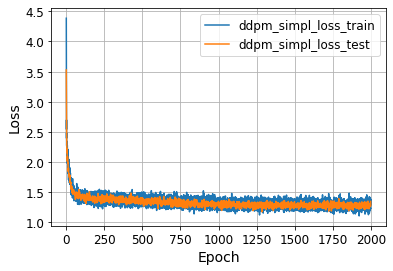

In [162]:
plot_training_curves(train_losses, test_losses)

In [163]:
ddpm.eval()
z = ddpm.sample(5000, save_history=False).detach().cpu().numpy()

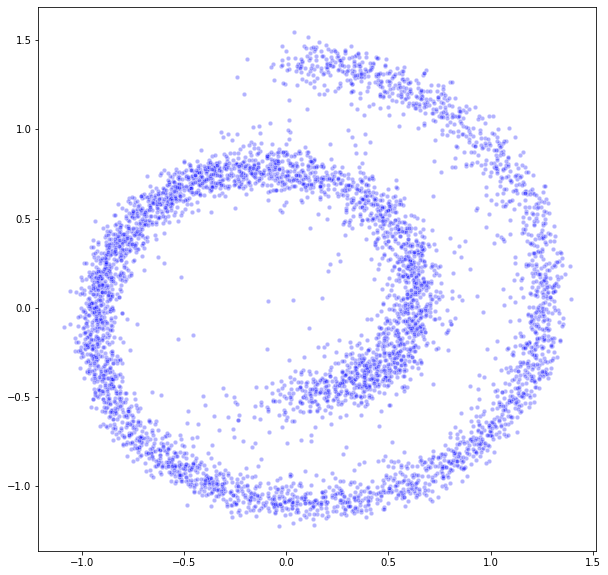

In [165]:
plt.figure(figsize=(10, 10))
plt.scatter(z[:, 0], z[:, 1], alpha=0.3, color='blue', edgecolor='white', s=20, label='modeled samples')
plt.show()